In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

# test for new prior function - redshift prior is basically set by observed line width 

#spec_wobs = norm(loc=3.,scale=0.05)

#xrange = np.linspace(2.,4.,100)

#pobs = spec_wobs.pdf(xrange)

#plt.plot(xrange,pobs)
#plt.show()

# halpha rest wavelength is 0.65

##rest = 0.65 

#pz = (pobs/rest)-1.

#plt.plot(xrange,pz)
#plt.show()

rest = 0.65 
pl = np.random.normal(loc=3.,scale=0.05,size=1000)

plt.hist(pl,histtype='step',bins=np.arange(2.5,3.5,0.01))
plt.show()

pz = (pl/rest)-1.

plt.hist(pz,histtype='step')
plt.show()


In [ ]:
nsamp = 64
xline = np.linspace(-nsamp, nsamp, 2*nsamp+1)/nsamp*0.1+1
yline = xline*0.
yline[nsamp] = 1
yline /= np.trapz(yline, xline)

In [ ]:
plt.plot(xline,yline)

In [ ]:
print(nsamp*0.1+1)

In [ ]:
print(xline)

In [ ]:
print(np.trapz(yline, xline))

In [ ]:
import os
from grizli import utils

In [ ]:
def resample_template_numba(spec_wobs, spec_R_fwhm, templ_wobs, templ_flux, velocity_sigma=100, nsig=5, fill_value=0.):
    """
    Resample a high resolution template/model on the wavelength grid of a
    spectrum with (potentially) wavelength dependent dispersion
    
    Parameters
    ----------
    spec_wobs : array-like
        Spectrum wavelengths
    
    spec_R_fwhm : array-like
        Spectral resolution `wave/d(wave)`, FWHM
    
    templ_wobs : array-like
        Template wavelengths, observed frame.  Same units as `spec_wobs`.  
        **NB:** both `spec_wobs` and `templ_wobs` assumed to be sorted!
    
    templ_flux : array-like
        Template flux densities sampled at `templ_wobs`
    
    velocity_sigma : float
        Kinematic velocity width, km/s
    
    nsig : float
        Number of sigmas of the Gaussian convolution kernel to sample
    
    Returns
    -------
    resamp : array-like
        Template resampled at the `spec_wobs` wavelengths, convolved with a 
        Gaussian kernel with sigma width
        
        >>> Rw = 1./np.sqrt((velocity_sigma/3.e5)**2 + 1./(spec_R_fwhm*2.35)**2)
        >>> dw = spec_wobs / Rw
    
    """    
    dw = np.sqrt((velocity_sigma/3.e5)**2 + (1./2.35/spec_R_fwhm)**2)*spec_wobs
    
    #Rw = 1./np.sqrt((velocity_sigma/3.e5)**2 + 1./(spec_R_fwhm*2.35)**2)
    # dw = spec_wobs / Rw
    
    ilo = 0
    ihi = 1
    
    N = len(spec_wobs)
    resamp = np.zeros_like(spec_wobs)*fill_value
    
    Nt = len(templ_wobs)
    
    for i in range(N):
        #sl = slice(ilo[i], ihi[i])
        while (templ_wobs[ilo] < spec_wobs[i]-nsig*dw[i]) & (ilo < Nt-1):
            ilo += 1
        
        if ilo == 0:
            continue
            
        ilo -= 1
        
        while (templ_wobs[ihi] < spec_wobs[i]+nsig*dw[i]) & (ihi < Nt):
            ihi += 1
        
        if (ilo >= ihi):
            resamp[i] = templ_flux[ihi]
            continue
        elif (ilo == Nt-1):
            break
            
        sl = slice(ilo, ihi)
        lsl = templ_wobs[sl]
        g = np.exp(-(lsl-spec_wobs[i])**2/2/dw[i]**2)/np.sqrt(2*np.pi*dw[i]**2)
        # g *= 1./np.sqrt(2*np.pi*dw[i]**2) 
        resamp[i] = np.trapz(templ_flux[sl]*g, lsl)
        
    return resamp

In [ ]:
res = self.resample_func(spec_wobs,
                                 spec_R_fwhm*scale_disp, 
                                 self.xline*line_um,
                                 self.yline,
                                 velocity_sigma=velocity_sigma,
                                 nsig=nsig)

In [19]:
import data
import os
import numpy as np
from scipy.interpolate import UnivariateSpline

In [8]:

test = data.Data(spectrum_file=os.path.abspath('../test_data/macs0417.1208_340.v0.spec.fits'),photometry_file=None,run_ID=1,phot_id=None)

spec1d found
Reading in spectrum with grating prism/clear combination
No photometry found


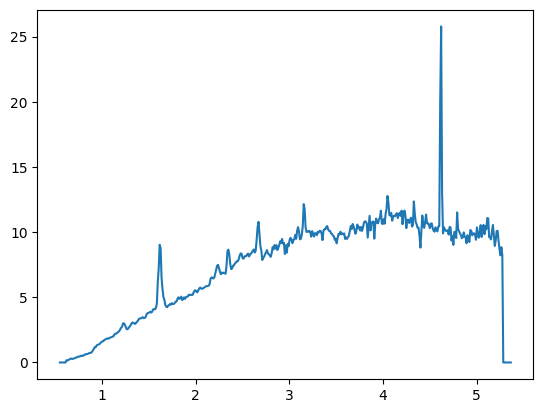

In [9]:
import matplotlib.pyplot as plt

plt.plot(test.spec_wobs,test.spec_fnu)

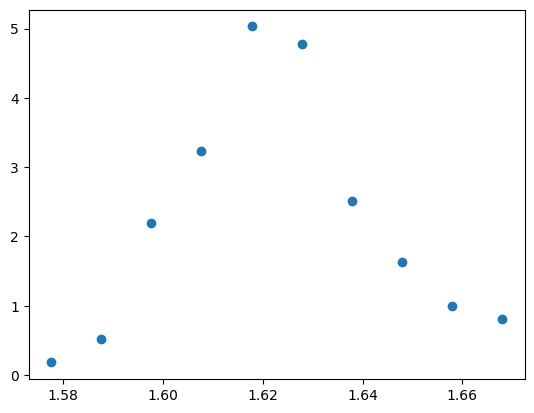

In [57]:
x1 = 1.575
x2 = 1.675

xsel = (test.spec_wobs>x1) & (test.spec_wobs<x2)
plt.scatter(test.spec_wobs[xsel],test.spec_fnu[xsel]-4.)

In [58]:
x = test.spec_wobs[xsel]
y = test.spec_fnu[xsel]


spline = UnivariateSpline(x, y-np.max(y)/2, s=0)
r1, r2 = spline.roots() # find the roots

ValueError: not enough values to unpack (expected 2, got 1)

In [55]:
spline

In [50]:
r1

1.5875416981783388

In [51]:
r2

1.6752321767367682

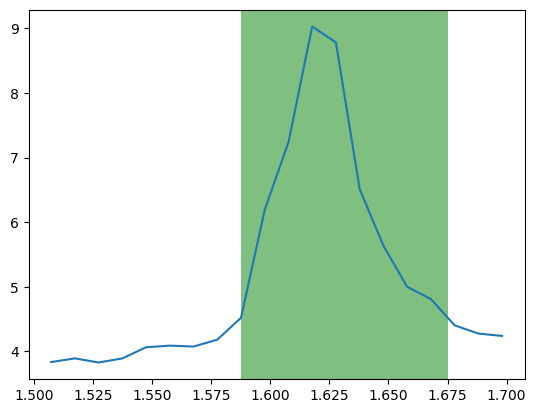

In [52]:
plt.plot(x,y)
plt.axvspan(r1, r2, facecolor='g', alpha=0.5)
plt.show()

In [46]:
ymax = np.nanmax(y)

hm = ymax/2.

# then find intersection of hm with x/y curve. 

In [62]:
def get_full_width(x: np.ndarray, y: np.ndarray, height: float = 0.5) -> float:
    height_half_max = np.max(y) * height
    index_max = np.argmax(y)
    x_low = np.interp(height_half_max, y[:index_max+1], x[:index_max+1])
    x_high = np.interp(height_half_max, np.flip(y[index_max:]), np.flip(x[index_max:]))

    return x_low,x_high,x_high - x_low


In [65]:
x1,x2,fwhm = get_full_width(x,y-4.)

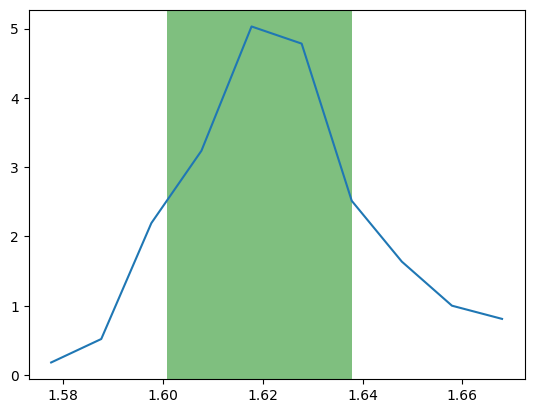

In [67]:
plt.plot(x,y-4.)
plt.axvspan(x1, x2, facecolor='g', alpha=0.5)
plt.show()